# <br><br><span style="color:rebeccapurple">Cross validation</span>

There are several types of cross validation (CV). In fact, the train/test split is sometimes referred to as the holdout method for CV. 

CV can be used for multiple purposes:
- Evaluate a model's performance and variability of model parameters
- Tune hyperparameters
- Compare the performance of different models (e.g. logistic regression vs decision tree)
- ...

There are several variations of CV. We will explore k-fold CV for evaluationg model performance. The data is randomly split into $k$ disjoint subparts or "folds" and each fold will take turn to be the test (hold-out) set while the rest are used for training.

<div>
<center><img src="figures/kfoldCV.png" width="500"/>
<center> Source: scikit-learn   

We will use CV to evaluate performance and check the variability of parameters for linear regression models. We won't have time to look into hyperparameter tuning. We will cover model comparison on the 2nd day. 

For example, in the figure above, we use a 5-fold CV. We will iterate through each fold. In iteration $i$, 
- take fold $i$ as the test/hold-out set
- train the model on the instances in the remaining folds and obtain a set of model parameters
- compute performance metrics (e.g. MSE) on the test set
    
In the end, we will have gone through 5 iterations and obtained 5 different sets of parameters along with 5 performance metrics. 

# <br><br><span style="color:rebeccapurple">Disadvantages</span>

The estimate of model performance via $k$-fold cross-validation depends heaviy on the specific split of the data into $k$ folds. For each different split, we obtain different subsets of the data and, consequently, a different distribution of performance scores. 

One solution is to repeat the $k$-fold cross-validation process multiple times. Repeated $k$-fold reports the mean performance across all folds and all repeats. 

# <br><br><span style="color:rebeccapurple">Let's code!</span>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [110]:
## Import data
df = pd.read_csv('datasets/fish.csv')
feature_names = df.columns.values[:-1]
# Split the dataset into predictors and response
X = df[feature_names]
Y = np.log(df['weight'])

## <br><span style="color:teal"> Build pipeline
    
We follow the same procedure to build the pipeline for preprocessing and model.

In [111]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# Create a pipeline to apply preprocessor
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder())]) #(chosen_name, transformer)
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

from sklearn.compose import ColumnTransformer
categorical_columns = ['species']
numerical_columns = feature_names[1:]  

# Create preprocessor pipeline using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_columns), #(chosen_name, Pipeline, columns_to_apply_to)
        ('cat', categorical_transformer, categorical_columns)])

from sklearn.linear_model import LinearRegression
model = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', LinearRegression())])

## <br><span style="color:teal"> Set up cross validation
    
We don't need to split the data into train/test set. The RepeatedKFold module in scikit-learn automatically creates the splits. 

Suppose we want to do a 5-fold CV and repeat the process 6 times.

In [112]:
from sklearn.model_selection import RepeatedKFold
cv = RepeatedKFold(n_splits=5, n_repeats=6, random_state=0)

Instead of calling model.fit(), we will need to use the cross_validate module to implement CV.

In [113]:
from sklearn.model_selection import cross_validate
cv_model = cross_validate(
    model,
    X,
    Y,
    cv=cv,
    return_estimator=True,
    scoring='r2',
)

The mean performance score of the model across all folds and all repeats is 

In [124]:
np.mean(cv_model['test_score'])

0.9698000989980726

We can also check the variability of the coefficients.

In [114]:
# Create a nice data frame to store the coefficients, not including the intercept/bias
labels = feature_names[1:].tolist() + list(cv_model['estimator'][0]['preprocessor'].transformers_[1][1]['onehot'].get_feature_names(categorical_columns))

coefs = pd.DataFrame(
    [
        est[-1].coef_ 
        for est in cv_model["estimator"]
    ],
    columns=labels,
)

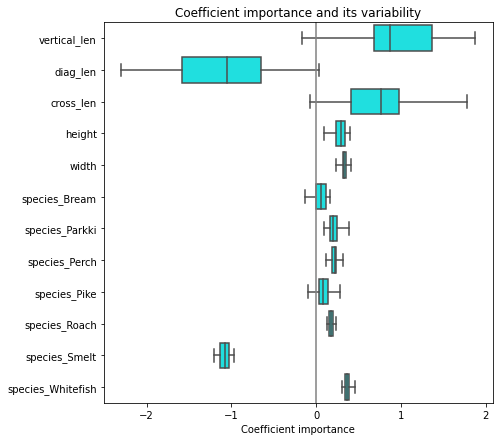

In [115]:
plt.figure(figsize=(9, 7))
# sns.stripplot(data=coefs, orient="h", color="k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", whis=10)
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient importance")
plt.title("Coefficient importance and its variability")
plt.subplots_adjust(left=0.3)

The vertical_len, diag_len and cross_len coefficients have strong variability across different subsets and this might be due to the collinearity among the 3 features. If they vary together in the data, their effect is difficult to tease apart.

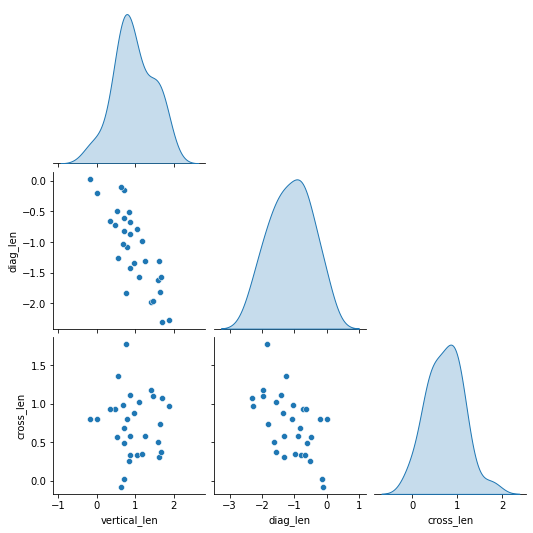

In [116]:
sns.pairplot(coefs[['vertical_len', 'diag_len', 'cross_len']], kind="scatter", diag_kind='kde', corner=True)

Text(0.5, 1.0, 'Co-variations of coefficients across folds')

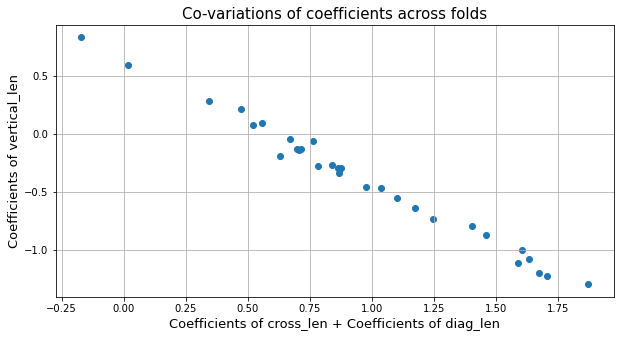

In [117]:
plt.figure(figsize=(10,5))
plt.scatter(coefs['vertical_len'], coefs['cross_len']+coefs['diag_len'])
plt.grid(True)
plt.ylabel("Coefficients of vertical_len", fontsize=13)
plt.xlabel("Coefficients of cross_len + Coefficients of diag_len", fontsize=13)
plt.title("Co-variations of coefficients across folds", fontsize=15)

# <br><span style="color:purple"> Additional materials

Remove cross_len and diag_len and redo the process.

In [119]:
feature_names_new = ['species', 'vertical_len', 'height', 'width']
X_new = df[feature_names_new]